Simulate various M2 moves. Find out which position produces most similar donuts to the detector shifted by `[0, -0.0328, 0]`,`[0, +0.0328, 0]`,

In [1]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

minZk = 4
maxZk = 23
minMagnitudeNm = 10
maxMagnitudeNm = 500

In [2]:
print(batoid.__version__)
print(galsim.__version__)
print(wfsim.__version__)

0.4.0
2.4.6
0.1.0


In [3]:

def simulate_defocal_atmosphere(seed = 10, image_shape_x=1000,image_shape_y=1000,
                               nproc=6,  shift_element='Detector', shift_array_intra=[0,0,-0.0328],
                               shift_array_extra=[0,0,+0.0328]):
    ''' 
    Simulate auxTel atmosphere only, one intra and one extra-focal simulator.
    
    This is a workaround to allow simulating different zernikes, but 
    with the same telescope setup and atmosphere.
    
    For some reason, trying to re-simulate the atmosphere & zks in a loop
    fails (as of 2/1/2023) -the simulation never finishes. 
    
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 204.8, # 819.2,
        "screen_scale": 0.1,
        "nproc": nproc,
        }
    
    
    # shift_element is Detector or M2 
    intra = auxtel.withGloballyShiftedOptic(
         shift_element, shift_array_intra) # meters 

    extra = auxtel.withGloballyShiftedOptic(
        shift_element, shift_array_extra)
   
        
    # Create an intra-focal simulator with just atmosphere:
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    # Create an extra-focal simulator with just atmosphere:
    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(image_shape_x, image_shape_y),
        rng=rng
    )
        
    return intra_simulator, extra_simulator 



def simulate_zernike_screen(intra_simulator, extra_simulator, 
                            z_in = np.array([0, 0, 0, 0, 0, 0, 0, 0,0, 0, 300e-9, 0]),
                            thxDeg=0, thyDeg=39/3600,
                            outDir = 'DM-37629',
                            fname = f"auxTel_batoid_test_zk",
                            shift_element='Detector',
                            shift_array_intra=[0, -0.0328, 0],
                            shift_array_extra=[0, +0.0328, 0]
                           ):
    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    ''' 
    Simulate auxTel donuts with input Zernike wavefront as phase screen.
    
    NB: 
    z_in contains z0,z1,z2....z11   
    so eg. z_in = [0,0,0,200e-9,0,0...] means z3=200e-9 [m],
    i.e. 200 nm 
    
    NB: z_in must be in meters! 
    So  eg. result of ts_wep fit, which is in nanometers, 
    needs to be converted to meters ! 
    z_meters = z_nm  * 1e-9 

    thxDeg : x-position of a star in degrees 
    thyDeg : y-position of a star in degrees 
    
    shift_element:  'Detector': [0, -0.0328, 0] , [0, +0.0328, 0] 
        or 'M2', for which use 
    
    '''

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
    )
    perturbed_telescope = batoid.CompoundOptic(
                (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name='PhaseScreen',
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=auxtel.stopSurface.coordSys
                ),
                *auxtel.items
            ),
            name='PerturbedAuxTel',
            backDist=auxtel.backDist,
            pupilSize=auxtel.pupilSize,
            inMedium=auxtel.inMedium,
            stopSurface=auxtel.stopSurface,
            sphereRadius=auxtel.sphereRadius,
            pupilObscuration=auxtel.pupilObscuration
        )

    
    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(thxDeg)
    thy = np.deg2rad(thyDeg)
    
        
    # Now run the image simulation:
    wavelength  =  intra_simulator.bandpass.effective_wavelength * 1e-9 # batoid wants meters 


    # NB: read out the zernikes BEFORE the telescope is shifted by +/- 8 mm ! 
    zk = batoid.zernike(perturbed_telescope, thx, thy, wavelength, eps=0.3525)
    zk *= wavelength  #  waves -> meters 
    
    
    # set the image simulator with the perturbed telescope 
    
    intra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic(
        shift_element, shift_array_intra
    )
    extra_perturbed_telescope = perturbed_telescope.withGloballyShiftedOptic(
        shift_element, shift_array_extra
    ) 
   
    # set the telescope of the simulator to the perturbed telescope 
    intra_simulator.telescope = intra_perturbed_telescope
    intra_simulator.image.setZero()
    
    extra_simulator.telescope = extra_perturbed_telescope
    extra_simulator.image.setZero()

    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    rng = intra_simulator.rng
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000  #rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)
    
    fpath = os.path.join(outDir,fname)
    np.savez(fpath,
             intra=intra_simulator.image.array,
             extra=extra_simulator.image.array,
             zk=zk,
             shift_element=shift_element,
             shift_array_intra=shift_array_intra,
             shift_array_extra=shift_array_extra
            )
    print(f'saved as {fname}')

    return intra_simulator, extra_simulator



Shift just the detector by the prescribed amount. Inject 100 nm of each Zk individually - that's the baseline.

In [4]:
import time 
t1 = time.time()
intra_simulator, extra_simulator  = simulate_defocal_atmosphere(image_shape_x=500,image_shape_y=500,
                                                                shift_element='Detector', 
                                                                shift_array_extra=[0, -0.0328, 0],
                                                                shift_array_intra=[0, +0.0328, 0]
                                                               )
t2 = time.time()
dt = t2-t1 #[seconds]
print(f'took {dt} seconds\n')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


took 6.569451570510864 seconds



In [ ]:
import time 

seed = 10
minZk = 4
maxZk = 11
minMagnitudeNm = 50
maxMagnitudeNm = 320
for i in range(minZk, maxZk):
    # i=10 gives zk9
    # i = 11  # i=11 gives zk10
    for f in np.linspace(minMagnitudeNm, maxMagnitudeNm, 10):
        z_in = np.zeros(maxZk) # always initialize array as empty...
        z_in[i] = f*1e-9
        print(i, z_in)
        t1 = time.time()
        #intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
        #                        fname = f"auxtel_b_seed{seed}_image_truth_z{i}")

        simulate_zernike_screen(intra_simulator, extra_simulator, 
                                z_in = z_in,
                                thxDeg=0, thyDeg=39/3600,
                                outDir = 'DM-38121',
                                fname = f"auxTel_det_zk{i}_{int(f)}nm_500px",
                                shift_element='Detector', 
                                shift_array_extra=[0, -0.0328, 0],
                                shift_array_intra=[0, +0.0328, 0]
                               )

        t2 = time.time()

        dt = t2-t1 #[seconds]
        print(f'took {dt} seconds\n')
print('All done! ')

Simulate for just one zk, eg. zk7=110 nm , but vary the M2 shift (instead of [0,0,-0.000788], [0,0,+0.0008], consider eg, 
                                                                  
      -0.7 mm to -0.85 mm, same with 
      +0.7 mm to +0.85 mm,

      every 0.01 mm
      
      M2_shifts_mm = np.arange(0.7,0.85, 0.001)
      
Also, conider eg. zk8 = 110 nm, vary M2 shift between 0.725, 0.825 :

      M2_shifts_mm = np.arange(0.725,0.825, 0.001)

Also do the same with zk4,5,6 and   9,10,11 : 

In [4]:
#M2_shifts_mm = np.arange(0.7,0.85, 0.001)
M2_shifts_mm = np.arange(0.7,0.85, 0.002)

In [5]:
M2_shifts_mm

array([0.7  , 0.702, 0.704, 0.706, 0.708, 0.71 , 0.712, 0.714, 0.716,
       0.718, 0.72 , 0.722, 0.724, 0.726, 0.728, 0.73 , 0.732, 0.734,
       0.736, 0.738, 0.74 , 0.742, 0.744, 0.746, 0.748, 0.75 , 0.752,
       0.754, 0.756, 0.758, 0.76 , 0.762, 0.764, 0.766, 0.768, 0.77 ,
       0.772, 0.774, 0.776, 0.778, 0.78 , 0.782, 0.784, 0.786, 0.788,
       0.79 , 0.792, 0.794, 0.796, 0.798, 0.8  , 0.802, 0.804, 0.806,
       0.808, 0.81 , 0.812, 0.814, 0.816, 0.818, 0.82 , 0.822, 0.824,
       0.826, 0.828, 0.83 , 0.832, 0.834, 0.836, 0.838, 0.84 , 0.842,
       0.844, 0.846, 0.848, 0.85 ])

In [ ]:
import time 

i = 9 # run for just one Zk 
f = 140 # nm of that Zk 
for i in range(4,7) : # zk4-6  
    for j in range(len(M2_shifts_mm)):
        shift = M2_shifts_mm[j]*0.001
        t1 = time.time()
        intra_simulator, extra_simulator  = simulate_defocal_atmosphere(image_shape_x=500,image_shape_y=500,
                                                                        shift_element='M2', 
                                                                        shift_array_extra=[0, 0, -shift],
                                                                        shift_array_intra=[0, 0, +shift]
                                                                       )
        t2 = time.time()
        dt = t2-t1 #[seconds]
        print(f'took {dt} seconds\n')


        seed = 10
        #minZk = 4
        #maxZk = 11
        #minMagnitudeNm = 50
        #maxMagnitudeNm = 320
          #for i in range(minZk, maxZk):
            # i=10 gives zk9
            # i = 11  # i=11 gives zk10
        #for f in np.linspace(minMagnitudeNm, maxMagnitudeNm, 10):

        z_in = np.zeros(maxZk) # always initialize array as empty...
        z_in[i] = f*1e-9
        print(i, z_in)
        t1 = time.time()
        #intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
        #                        fname = f"auxtel_b_seed{seed}_image_truth_z{i}")

        simulate_zernike_screen(intra_simulator, extra_simulator, 
                                z_in = z_in,
                                thxDeg=0, thyDeg=39/3600,
                                outDir = 'DM-38121',
                                fname = f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px",
                                shift_element='M2', 
                                shift_array_extra=[0, 0, -shift],
                                shift_array_intra=[0, 0, +shift]
                               )

        t2 = time.time()
        dt = t2-t1 #[seconds]
        print(f'took {dt} seconds\n')
    print('All done! ')

Consider just this one zk7=110 nm . Which M2 shift best reproduces the detector shift? 

In [42]:
xt,yt=1.1,0.5
xc=500
yc=500
w=120

#, u)#, dpi=100)


fname = f"auxTel_det_zk{i}_{int(f)}nm_500px.npz"
fpath = os.path.join('DM-38121',fname)
det = np.load(fpath)

#i = 7 # only x-coma
f = 110 # nm 
m2s = {}
shift_arr = M2_shifts_mm*0.001
for shift in shift_arr:
    #print(shift)
    fname= f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px.npz"
    fpath = os.path.join('DM-38121',fname)
    m2 = np.load(fpath)
    m2s[shift] = m2
    

Would need to run donut detection and then subtract the individual donut postage stamps, because the donuts from the detector and from each shift of M2 are in different locations slightly and that contributes most to the difference between the detector and the M2 donts 

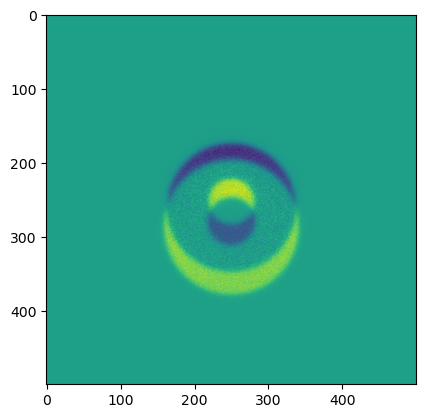

In [50]:
plt.imshow(det['intra']-m2s[shift_arr[25]]['intra'] )

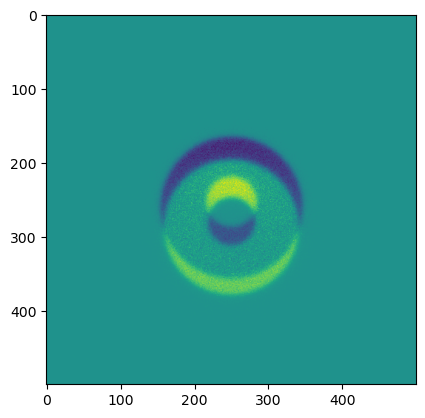

In [48]:
plt.imshow(det['intra']-m2s[shift_arr[100]]['intra'] )

Run donut detection and cut out postage stamps:

In [8]:
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
)

from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTaskConfig, CutOutDonutsScienceSensorTask
)

In [9]:
import analysis_tools as at 

In [10]:
from lsst.obs.lsst import Latiss
from copy import copy


def make_donuts(intra_image,extra_image,fname):
    # common settings for donut detection task,
    # donut cutting out task zernike estimation task...
    focalLength = 21.6 # meters 
    obscuration = 0.3525 # ratio 
    apertureDiameter = 1.2 # meters 
    defocalOffset = 32.8 
    pixelSize = 10.0e-6 # meters 
    opticalModel = 'onAxis'
    donutSize = 240 


    intra_exposure = at.make_exposure(extra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(intra_image, focusZ=-0.8)

    maskPlaneDict = {'BAD': 1, 'CR': 2, 'DETECTED': 0, 'DETECTED_NEGATIVE': 3, 
                     'EDGE': 4, 'INTRP': 5, 'NO_DATA': 6, 'SAT': 7, 
                     'SUSPECT': 8, 'UNMASKEDNAN': 9}
    intra_exposure.mask.clearMaskPlaneDict()
    intra_exposure.mask.conformMaskPlanes(maskPlaneDict) 


    extra_exposure.mask.clearMaskPlaneDict()
    extra_exposure.mask.conformMaskPlanes(maskPlaneDict) 


    print(id(intra_exposure))

    # pass to WEP, fit transposed and untransposed 
    newConfig = GenerateDonutDirectDetectTaskConfig()
    newConfig.measurementTask.nSigmaDetection = 5
    newConfig.initialCutoutPadding = 40
    newConfig.instObscuration = obscuration
    newConfig.instFocalLength = focalLength
    newConfig.instApertureDiameter = apertureDiameter
    newConfig.instDefocalOffset = defocalOffset
    newConfig.instPixelSize = pixelSize
    newConfig.opticalModel = opticalModel

    # Set donut selection parameters
    newConfig.donutSelector.useCustomMagLimit = True
    newConfig.donutSelector.magMin = 8.
    newConfig.donutSelector.magMax = 20.
    newConfig.donutSelector.unblendedSeparation = 200

    camera = Latiss().getCamera()
    newTask = GenerateDonutDirectDetectTask(config=newConfig)
    donut_catalog_intra = newTask.run(copy(intra_exposure), camera).donutCatalog
    donut_catalog_extra = newTask.run(copy(extra_exposure), camera).donutCatalog

    cutOutConfig = CutOutDonutsScienceSensorTaskConfig()
    cutOutConfig.instObscuration = obscuration
    cutOutConfig.instFocalLength = focalLength
    cutOutConfig.instApertureDiameter = apertureDiameter
    cutOutConfig.instDefocalOffset = defocalOffset
    cutOutConfig.instPixelSize = pixelSize
    cutOutConfig.opticalModel = opticalModel
    cutOutConfig.donutStampSize = donutSize
    cutOutConfig.donutTemplateSize = donutSize
    cutOutConfig.initialCutoutPadding = 40

    cutOutTask = CutOutDonutsScienceSensorTask(config=cutOutConfig)
    cutOuts = cutOutTask.run([extra_exposure, intra_exposure], 
                             [donut_catalog_extra, donut_catalog_intra ], 
                             camera)

    fpath = os.path.join('DM-38121',f'{fname[:-4]}_stamps')
    print(f'Saved as {fpath}')
    np.savez(fpath,
             donutIntra=cutOuts.donutStampsIntra,
             donutExtra=cutOuts.donutStampsExtra
            )

Make donuts for the detector simulation:

In [11]:
fname = f"auxTel_det_zk{i}_{int(f)}nm_500px.npz"
fpath = os.path.join ('DM-38121',fname)
det = np.load(fpath)
make_donuts(det['intra'],det['extra'],fname)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector


140700755914544


INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 1 of 1 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/1 references


Saved as DM-38121/auxTel_det_zk8_110nm_500px_stamps


In [128]:
#fpath = os.path.join('DM-38121',f"auxTel_det_zk{i}_{int(f)}nm_500px_stamps.npz")
#npz = np.load(fpath, allow_pickle=True)
#plt.imshow(npz['donutIntra'])

Do the same for all the donuts resulting from M2 shift for that zk value:

In [ ]:
#i=7
f=110
shift_arr = M2_shifts_mm*0.001
for shift in shift_arr:
    #print(shift)
    fname= f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px.npz"
    fpath = os.path.join('DM-38121', fname)
    npz = np.load(fpath)
    make_donuts(npz['intra'],npz['extra'],fname)

Print a few of these with different M2 shifts to check that they are centered - the differences between images are just because of their tiny shape differences:

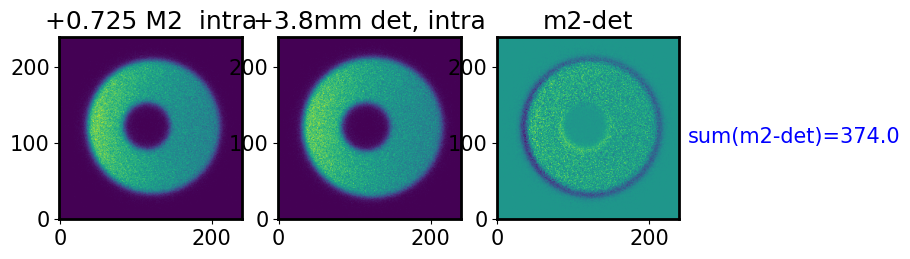

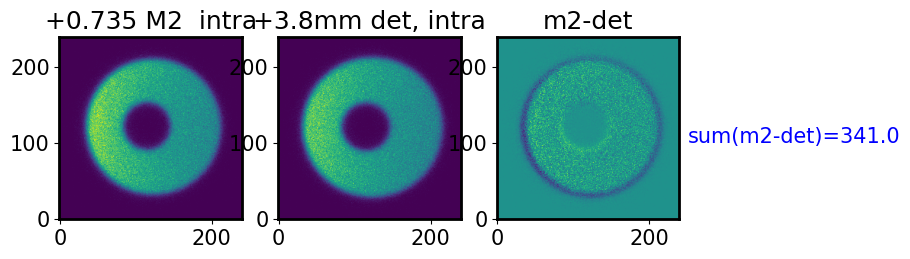

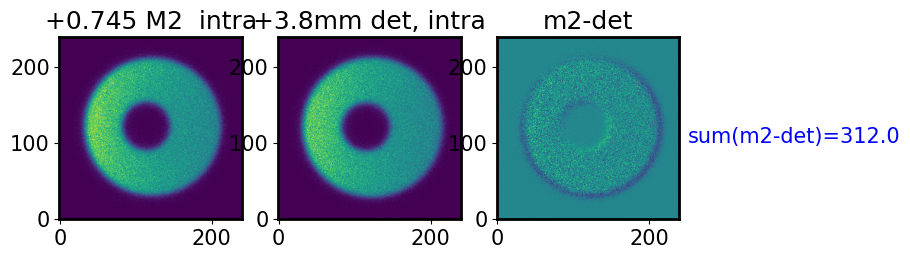

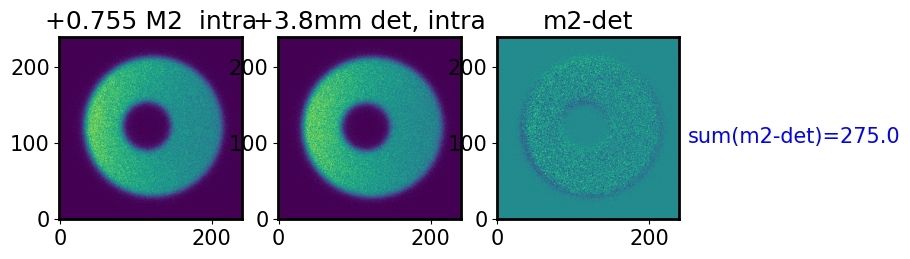

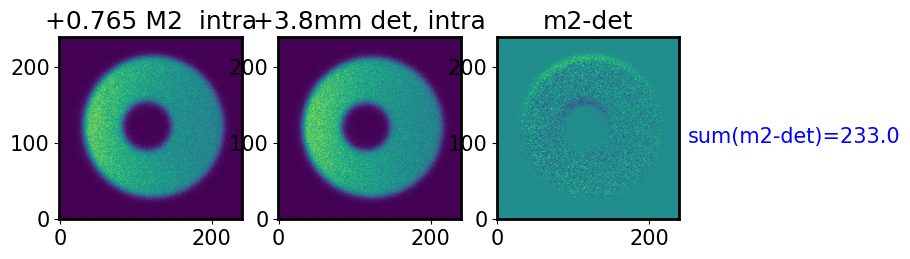

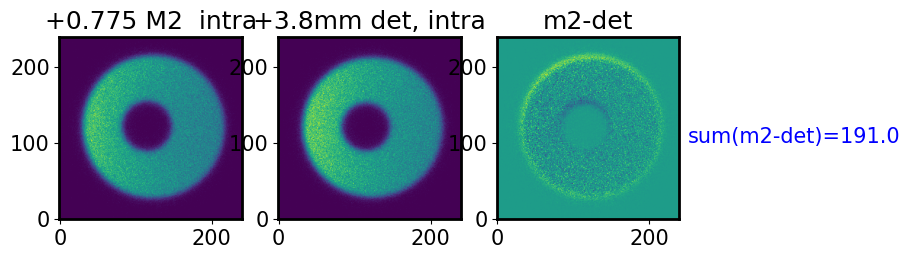

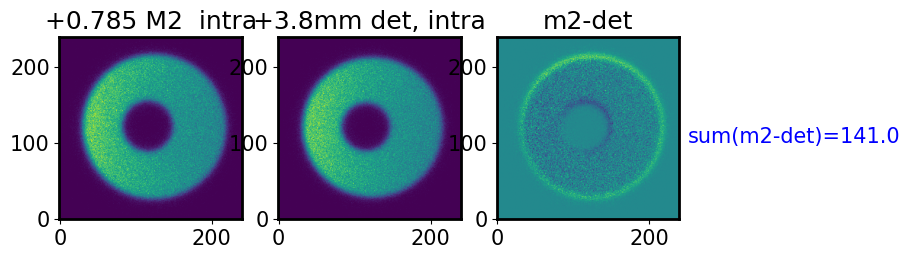

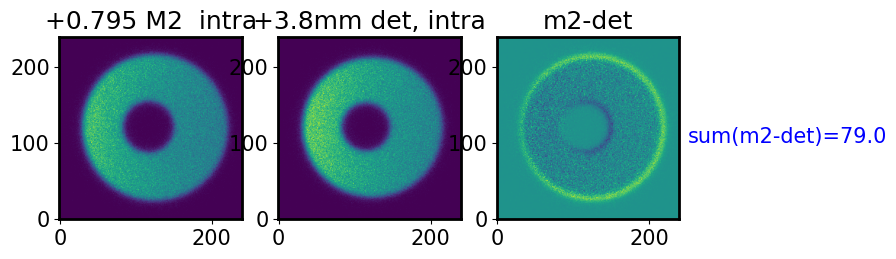

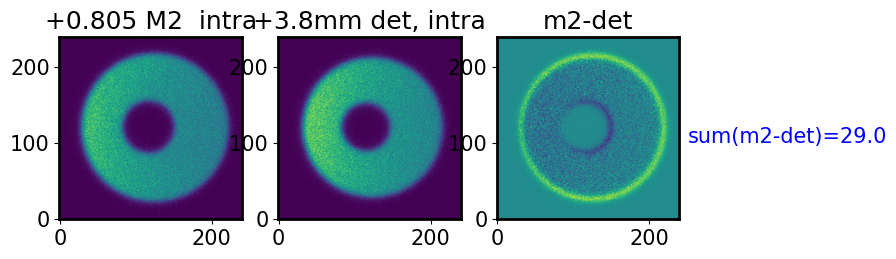

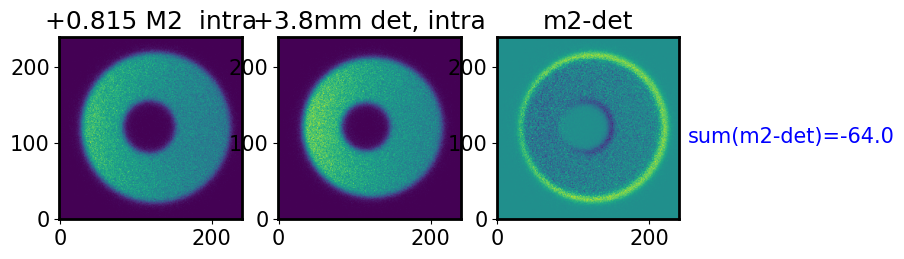

In [13]:
fpath = os.path.join('DM-38121',f"auxTel_det_zk{i}_{int(f)}nm_500px_stamps.npz")
det = np.load(fpath, allow_pickle=True)


for shift in shift_arr[::10]:
#shift = shift_arr[0]#for shift in shift_arr[::10]:
    fpath = os.path.join('DM-38121',f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px_stamps.npz")
    npz = np.load(fpath, allow_pickle=True)


    fig,ax = plt.subplots(1,3,figsize=(8,3))
    im1 = npz['donutIntra'][0].stamp_im.image.array
    ax[0].imshow(im1, origin='lower')
    ax[0].set_title(f'+{np.round(shift*1e3,3)} M2  intra')

    im2 = det['donutIntra'][0].stamp_im.image.array
    ax[1].imshow(im2, origin='lower')
    ax[1].set_title(f'+3.8mm det, intra')

    ax[2].imshow(im1-im2, origin='lower')
    ax[2].set_title('m2-det')
    diff = np.sum(im1-im2)
    ax[2].text(250,100,f'sum(m2-det)={diff}',c='b')

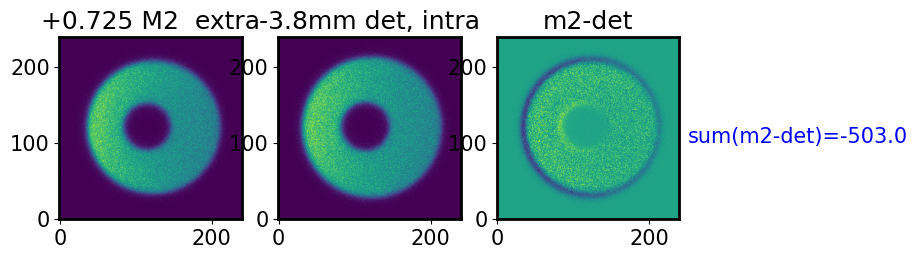

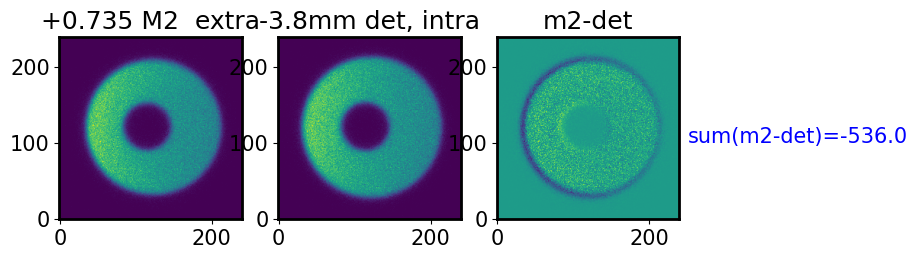

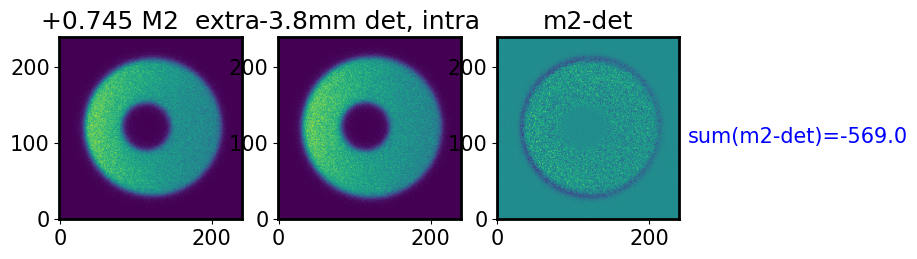

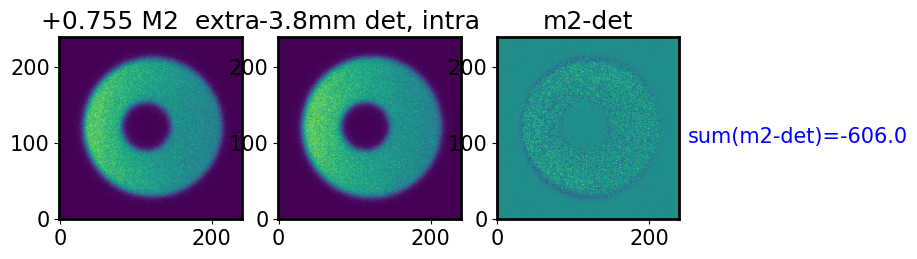

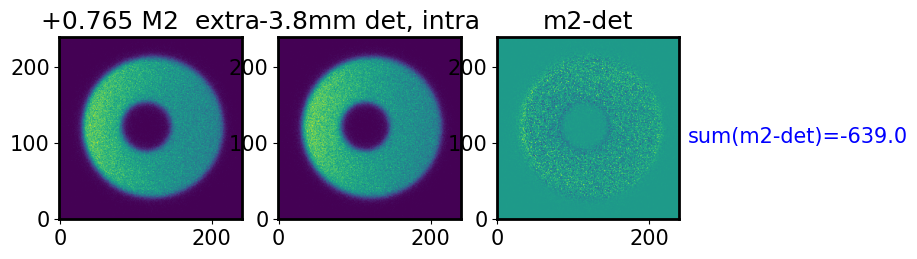

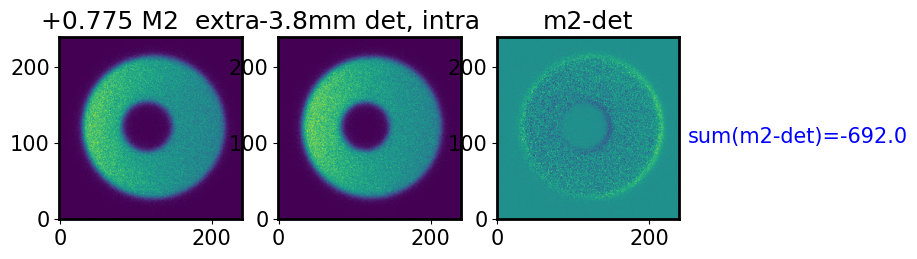

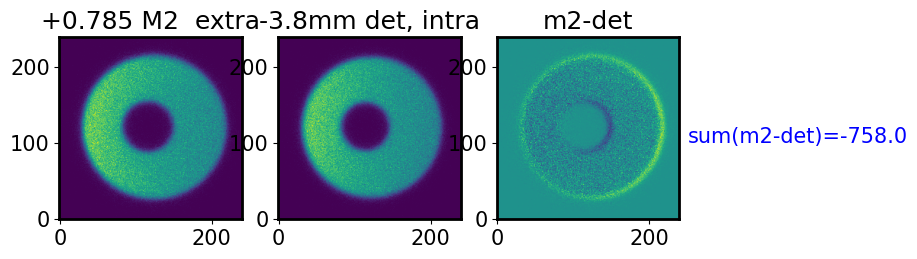

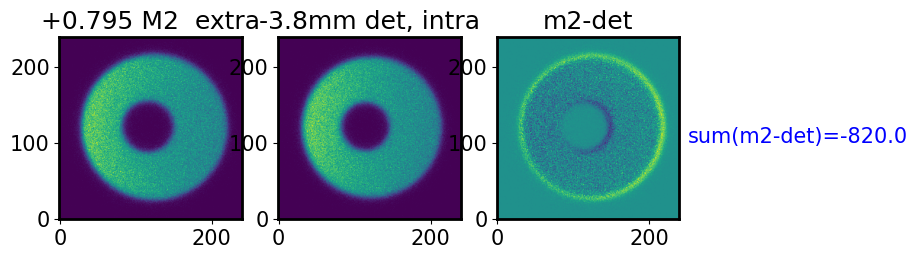

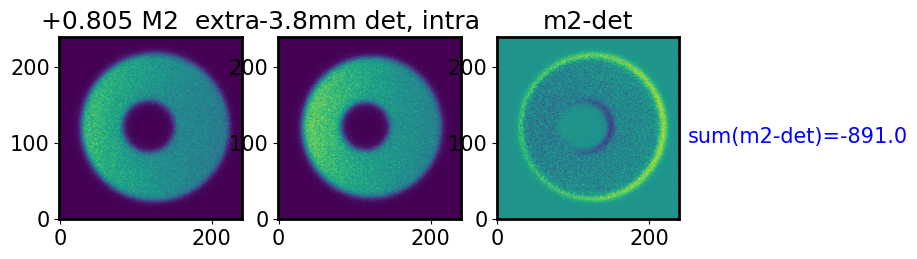

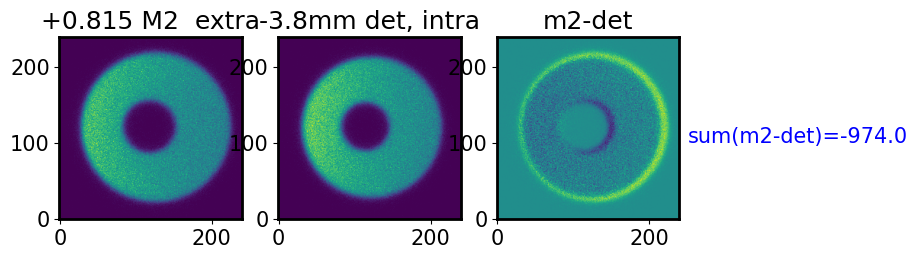

In [14]:
fpath = os.path.join('DM-38121',f"auxTel_det_zk{i}_{int(f)}nm_500px_stamps.npz")
det = np.load(fpath, allow_pickle=True)


for shift in shift_arr[::10]:
#shift = shift_arr[0]#for shift in shift_arr[::10]:
    fpath = os.path.join('DM-38121',f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px_stamps.npz")
    npz = np.load(fpath, allow_pickle=True)


    fig,ax = plt.subplots(1,3,figsize=(8,3))
    im1 = npz['donutExtra'][0].stamp_im.image.array
    ax[0].imshow(im1, origin='lower')
    ax[0].set_title(f'+{np.round(shift*1e3,3)} M2  extra')

    im2 = det['donutExtra'][0].stamp_im.image.array
    ax[1].imshow(im2, origin='lower')
    ax[1].set_title(f'-3.8mm det, intra')

    ax[2].imshow(im1-im2, origin='lower')
    ax[2].set_title('m2-det')
    diff = np.sum(im1-im2)
    ax[2].text(250,100,f'sum(m2-det)={diff}',c='b')

So given that, consider calculating the difference as we sweep the +0.7:+0.85mm for intra,  to -0.7:-0.85mm for extra  

In [165]:
fpath = os.path.join('DM-38121',f"auxTel_det_zk{i}_{int(f)}nm_500px_stamps.npz")
det = np.load(fpath, allow_pickle=True)

diffs = {'Intra':[], 'Extra':[]}
for defocal in ['Intra','Extra']:
    for shift in shift_arr:
        fpath = os.path.join('DM-38121',f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px_stamps.npz")
        npz = np.load(fpath, allow_pickle=True)

        im1 = npz[f'donut{defocal}'][0].stamp_im.image.array
        im2 = det[f'donut{defocal}'][0].stamp_im.image.array
        diff = np.sum(im1-im2)
        diffs[defocal].append(diff)

Note the nomenclature:
    
    extra shift detector  [0, -0.0328, 0]   M2 [0, 0, -0.8] --> intra donut
    intra shift detector  [0, +0.0328, 0]   M2 [0, 0, +0.8] --> extra donut 
    
    
for `zk7`  the difference between `intra` detector and `extra` M2 move yielded the best results. 

but for `zk8` we've got a different situation: `intra`detector  - `intra`  M2 gives the minimum! 

In [18]:
fpath = os.path.join('DM-38121',f"auxTel_det_zk{i}_{int(f)}nm_500px_stamps.npz")
det = np.load(fpath, allow_pickle=True)

diffs = []
for shift in shift_arr:
    fpath = os.path.join('DM-38121',f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px_stamps.npz")
    npz = np.load(fpath, allow_pickle=True)

    im1 = npz[f'donutIntra'][0].stamp_im.image.array
    im2 = det[f'donutIntra'][0].stamp_im.image.array
    diff = np.sum(im1-im2)
    diffs.append(diff)

This is saying that the most similar donut to a **shift of detector by [0, +0.0328, 0]  is a shift of [0, 0, -0.781]**

In [23]:
#diffs

In [21]:
-1000*shift_arr[np.where(diffs==np.min(np.abs(diffs)))]

array([-0.806])

Text(0, 0.5, 'diff [px]')

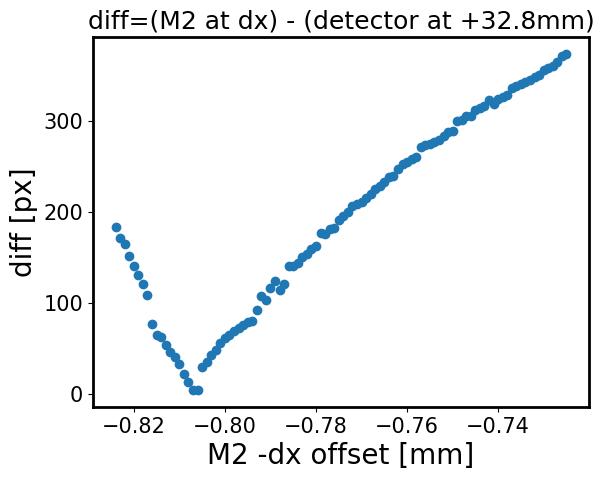

In [24]:
plt.scatter(-1000*shift_arr, np.abs(diffs))
plt.xlabel('M2 -dx offset [mm]')
plt.title('diff=(M2 at dx) - (detector at -32.8mm)')
plt.ylabel('diff [px]')

In [36]:
diffs = []
for shift in shift_arr:
    fpath = os.path.join('DM-38121',f"auxTel_M2_shift_{shift}_zk{i}_{int(f)}nm_500px_stamps.npz")
    npz = np.load(fpath, allow_pickle=True)

    im1 = npz[f'donutExtra'][0].stamp_im.image.array
    im2 = det[f'donutIntra'][0].stamp_im.image.array
    diff = np.sum(im1-im2)
    diffs.append(diff)

In [37]:
1000*shift_arr[np.where(diffs==np.min(np.abs(diffs)))]

array([0.732])

This is saying that the most similar donut to a **shift of detector by [0, -0.0328, 0]  is a shift of [0, 0, +0.781]**

Text(0, 0.5, 'diff [px]')

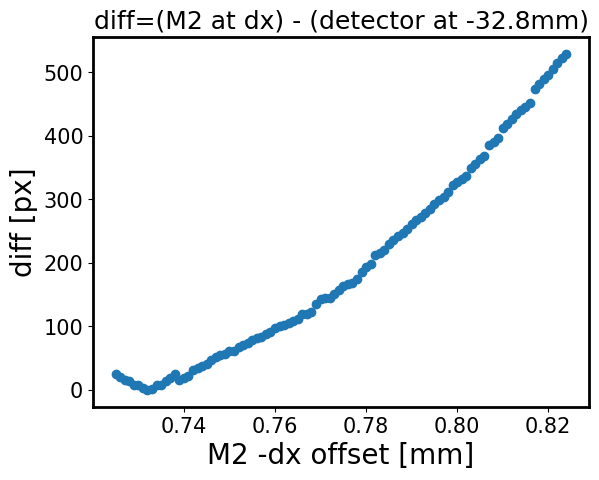

In [38]:
plt.scatter(1000*shift_arr, np.abs(diffs))
plt.xlabel('M2 -dx offset [mm]')
plt.title('diff=(M2 at dx) - (detector at -32.8mm)')
plt.ylabel('diff [px]')

So with that method, comparing only Z7 at 110 nm, I find that there is a symmetry as long as we're using M2 at +/-0.781mm, in the opposite sense to detector movement (-/+ 3.28 mm...) 

This shows that there is a position for the extra-focal, i.e. where detector is shifted by -3.8mm, 
it is best represented by shift of M2 by about -0.824 mm

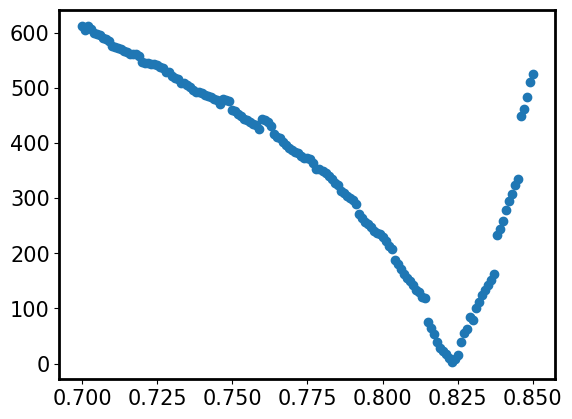

In [179]:
plt.scatter(res['shift']*1000, abs(res['Intra']))